In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd


df = pd.read_csv(
    'bd_solos_para_redape.csv',
    sep=';',              # separador ponto e vírgula
    quotechar='"',        # aspas usadas para campos com ponto e vírgula dentro
    encoding='utf-8',     # ou 'latin1' se UTF-8 falhar
    header=0,             # força uso da primeira linha como cabeçalho
    on_bad_lines = 'skip' #pula linhas defeituosas
)


df.columns = df.columns.str.strip()

/tmp/ipython-input-3914636026.py:4: DtypeWarning: Columns (0,3,4,25,34,35,48,52,53,56,57,58,62,63,64,65,66,67,68,69,70,71,73,74,75,87,88,91,92,93,94,95,96,97,98,99,100,101,102,119,120,140,141,142,149,150,151,152,153,154,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [ ]:
df_selected = df[['Nitrogênio total',
           'Complexo Sortivo - Hidrogênio (H+)',
           'Relação C/N (%)',
           'Cor da Amostra Úmida - Valor',
           'Cor da Amostra Úmida - Croma',
           'Profundidade Inferior',
           'Profundidade Superior',
           'Retenção de Umidade - 1,500 (MPa)',
           'Complexo Sortivo - Valor S (Ca2++Mg2++K++Na+)',
           'Complexo Sortivo - Cálcio (cmolc/kg)', 'Carbono orgânico']]



In [ ]:
df_selected['Carbono orgânico'].unique()

array([ 11.1,   3.6,   6.9, ...,  82.1,  69.1, 377.2])

In [ ]:
from sklearn.impute import KNNImputer


numeric_cols = df_selected.select_dtypes(include=['float64', 'int64']).columns.tolist()


imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_selected[numeric_cols]), columns=numeric_cols)


print("Valores nulos após KNNImputer:", df_imputed.isnull().sum().sum())

Valores nulos após KNNImputer: 0


In [ ]:

high_null_cols = df_selected.columns[df_selected.isnull().mean() > 0.3].tolist()

for col in high_null_cols:
    df_imputed[f'{col}_missing'] = df_selected[col].isnull().astype(int)

In [ ]:

df_imputed['Razao_CN'] = np.where(
    df_imputed['Nitrogênio total'] > 0,
    df_imputed['Carbono orgânico'] / df_imputed['Nitrogênio total'],
    np.nan
)


df_imputed['Profundidade_Media'] = (df_imputed['Profundidade Superior'] + df_imputed['Profundidade Inferior']) / 2

In [ ]:

from sklearn.preprocessing import OneHotEncoder
df_imputed.loc[df_imputed['Cor da Amostra Úmida - Valor'] > 10, 'Cor da Amostra Úmida - Valor'] = 0


df_imputed['Cor_Valor_Cat'] = pd.cut(df_imputed['Cor da Amostra Úmida - Valor'], bins=[0, 2, 4, 6, 10], labels=['Baixa', 'Média', 'Alta', 'Muito Alta'])

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = encoder.fit_transform(df_imputed[['Cor_Valor_Cat']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['Cor_Valor_Cat']))


df_imputed = pd.concat([df_imputed, encoded_df], axis=1)
df_imputed.drop('Cor_Valor_Cat', axis=1, inplace=True)

In [ ]:
df_imputed.head()
#print(df_imputed["Cor da Amostra Úmida - Valor"].unique())
#print(df_imputed['Cor da Amostra Úmida - Valor'].max())


,Nitrogênio total,Complexo Sortivo - Hidrogênio (H+),Relação C/N (%),Cor da Amostra Úmida - Valor,Cor da Amostra Úmida - Croma,Profundidade Inferior,Profundidade Superior,"Retenção de Umidade - 1,500 (MPa)",Complexo Sortivo - Valor S (Ca2++Mg2++K++Na+),Complexo Sortivo - Cálcio (cmolc/kg),Carbono orgânico,"Retenção de Umidade - 1,500 (MPa)_missing",Complexo Sortivo - Cálcio (cmolc/kg)_missing,Razao_CN,Profundidade_Media,Cor_Valor_Cat_Baixa,Cor_Valor_Cat_Muito Alta,Cor_Valor_Cat_Média,Cor_Valor_Cat_nan
0,1.0,1.3,8.2,4.0,4.0,10.0,0.0,9.334,0.2,0.154,11.1,1,1,11.1,5.0,0.0,0.0,1.0,0.0
1,0.5,0.3,9.0,5.0,5.8,100.0,60.0,14.316,0.1,0.156,3.6,1,1,7.2,80.0,0.0,0.0,0.0,0.0
2,0.6,0.4,11.0,4.0,6.0,60.0,10.0,17.100,0.1,0.548,6.9,1,1,11.5,35.0,0.0,0.0,1.0,0.0
3,0.3,0.2,4.2,5.0,6.0,190.0,140.0,12.520,0.4,1.566,0.6,1,1,2.0,165.0,0.0,0.0,0.0,0.0
4,0.4,0.8,5.8,5.0,6.0,140.0,30.0,15.740,0.6,1.680,0.8,1,1,2.0,85.0,0.0,0.0,0.0,0.0


In [ ]:

X = df_imputed.drop('Carbono orgânico', axis=1)
y = df_imputed['Carbono orgânico']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

imputer = KNNImputer(n_neighbors=5)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)



X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)


print("Valores NaN após tratamento:", X_train_imputed.isna().sum().sum())

results = {}

Valores NaN após tratamento: 0


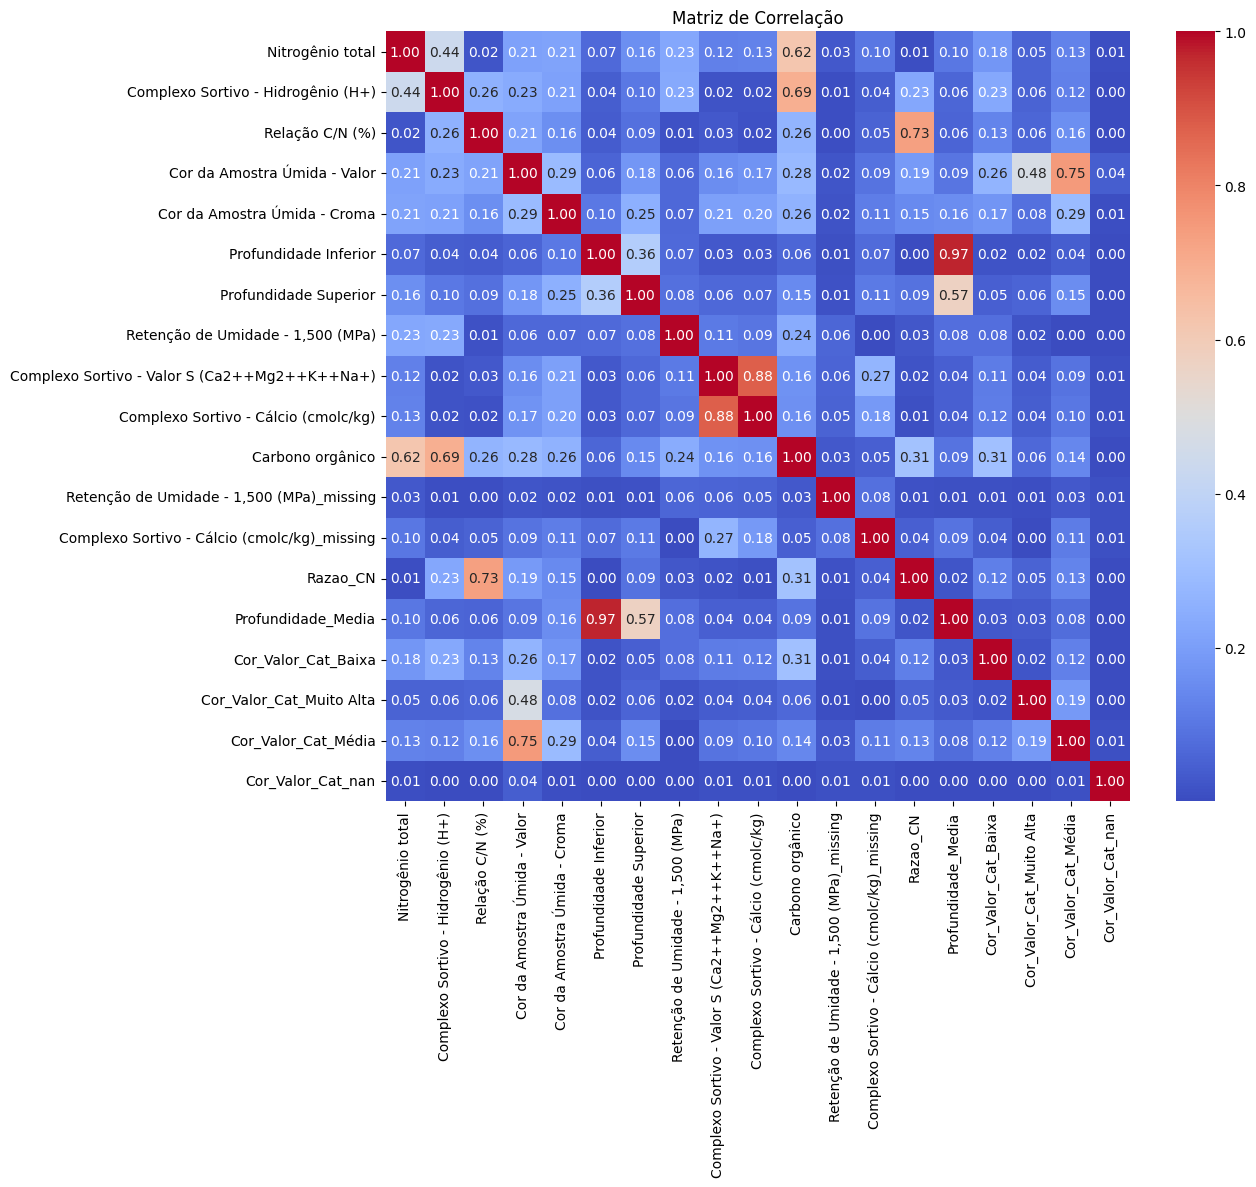

Features a remover (multicolinearidade): ['Profundidade_Media']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


corr_matrix = df_imputed.corr().abs()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Features a remover (multicolinearidade):", to_drop)


df_final = df_imputed.drop(to_drop, axis=1)

In [ ]:
df_final.head()

,Nitrogênio total,Complexo Sortivo - Hidrogênio (H+),Relação C/N (%),Cor da Amostra Úmida - Valor,Cor da Amostra Úmida - Croma,Profundidade Inferior,Profundidade Superior,"Retenção de Umidade - 1,500 (MPa)",Complexo Sortivo - Valor S (Ca2++Mg2++K++Na+),Complexo Sortivo - Cálcio (cmolc/kg),Carbono orgânico,"Retenção de Umidade - 1,500 (MPa)_missing",Complexo Sortivo - Cálcio (cmolc/kg)_missing,Razao_CN,Cor_Valor_Cat_Baixa,Cor_Valor_Cat_Muito Alta,Cor_Valor_Cat_Média,Cor_Valor_Cat_nan
0,1.0,1.3,8.2,4.0,4.0,10.0,0.0,9.334,0.2,0.154,11.1,1,1,11.1,0.0,0.0,1.0,0.0
1,0.5,0.3,9.0,5.0,5.8,100.0,60.0,14.316,0.1,0.156,3.6,1,1,7.2,0.0,0.0,0.0,0.0
2,0.6,0.4,11.0,4.0,6.0,60.0,10.0,17.100,0.1,0.548,6.9,1,1,11.5,0.0,0.0,1.0,0.0
3,0.3,0.2,4.2,5.0,6.0,190.0,140.0,12.520,0.4,1.566,0.6,1,1,2.0,0.0,0.0,0.0,0.0
4,0.4,0.8,5.8,5.0,6.0,140.0,30.0,15.740,0.6,1.680,0.8,1,1,2.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


model = RandomForestRegressor(n_estimators=100, random_state=42)



r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')


y_pred = cross_val_predict(model, X, y, cv=5)
rmse = np.sqrt(mean_squared_error(y, y_pred))

results['RandomForest'] = {
    'R²': round(np.mean(r2_scores), 4),
    'RMSE': round(rmse, 4),
    'R² por fold': [round(score, 4) for score in r2_scores]
}

print("Resultados do RandomForestRegressor:")
print(f"Média R²: {results['RandomForest']['R²']}")
print(f"RMSE: {results['RandomForest']['RMSE']}")
print("\nR² por fold:")
for i, score in enumerate(results['RandomForest']['R² por fold']):
    print(f"  Fold {i+1}: {score}")

Resultados do RandomForestRegressor:
Média R²: 0.956
RMSE: 4.0596

R² por fold:
  Fold 1: 0.974
  Fold 2: 0.949
  Fold 3: 0.9283
  Fold 4: 0.9412
  Fold 5: 0.9875


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgbr.fit(X_train, y_train)


y_pred = xgbr.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

results['XGBoost'] = {
    'R²': round(r2, 4),
    'RMSE': rmse,
}

print(f"XGBoost RMSE: {results['XGBoost']['RMSE']}")
print(f"XGBoost R²: {results['XGBoost']['R²']}")


XGBoost RMSE: 2.774105884019339
XGBoost R²: 0.9772


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

pipe = make_pipeline(
    StandardScaler(),
    SVR()
)

param_dist = {
    'svr__C': np.logspace(-1, 2, 4),
    'svr__epsilon': [0.1, 0.5],
    'svr__kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=8,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_imputed, y_train)

best_svr = random_search.best_estimator_
y_pred = best_svr.predict(X_test_imputed)

print("Melhores parâmetros:", random_search.best_params_)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"R²: {r2_score(y_test, y_pred):.4f}")

results['SVR'] = {
    'R²': round(r2_score(y_test, y_pred), 4),
    'RMSE': round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
}


Melhores parâmetros: {'svr__kernel': 'rbf', 'svr__epsilon': 0.5, 'svr__C': np.float64(100.0)}
RMSE: 6.9281
R²: 0.8579


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_imputed, y_train)
y_pred = ridge.predict(X_test_imputed)


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Regressão Linear RMSE: {rmse:.4f}")
print(f"Regressão Linear R²: {r2:.4f}")

results['Ridge'] = {
    'R²': round(r2, 4),
    'RMSE': round(rmse, 4)}


Regressão Linear RMSE: 9.5716
Regressão Linear R²: 0.7288


In [ ]:
from sklearn.linear_model import LassoCV


lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=42)

lasso_cv.fit(X_train_imputed, y_train)


y_pred = lasso_cv.predict(X_test_imputed)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Melhor alpha: {lasso_cv.alpha_:.5f}")
print(f"LassoCV RMSE: {rmse:.4f}")
print(f"LassoCV R²: {r2:.4f}")

results['LassoCV'] = {
    'R²': round(r2, 4),
    'RMSE': round(rmse, 4),
    'Melhor alpha': lasso_cv.alpha_
}


Melhor alpha: 0.00869
LassoCV RMSE: 9.5690
LassoCV R²: 0.7289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.472e+05, tolerance: 9.769e+02
  model = cd_fast.enet_coordinate_descent(



Melhor valor de k: 5
RMSE: 8.8445
R²: 0.7684


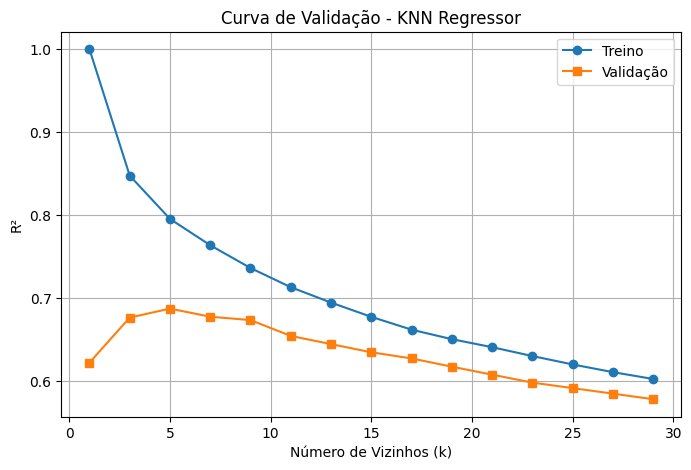

In [ ]:

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer



param_grid = {'n_neighbors': list(range(1, 31, 2))}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)


grid_search.fit(X_train_imputed, y_train)

best_knn = grid_search.best_estimator_
melhor_k = grid_search.best_params_['n_neighbors']

y_pred = best_knn.predict(X_test_imputed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nMelhor valor de k: {melhor_k}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

results['KNN'] = {
    'R²': round(r2, 4),
    'RMSE': round(rmse, 4),
    'Melhor k': melhor_k
}

param_range = list(range(1, 31, 2))
train_scores, test_scores = validation_curve(
    KNeighborsRegressor(), X_train_imputed, y_train,
    param_name="n_neighbors",
    param_range=param_range,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Treino", marker='o')
plt.plot(param_range, test_mean, label="Validação", marker='s')
plt.xlabel("Número de Vizinhos (k)")
plt.ylabel("R²")
plt.title("Curva de Validação - KNN Regressor")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeRegressor(random_state=2020)
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='r2', n_jobs=1, verbose=2)

grid_search.fit(X_train_imputed, y_train)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test_imputed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

results['DecisionTree'] = {
    'R²': round(r2, 4),
    'RMSE': round(rmse, 4),
    'Melhor profundidade': grid_search.best_params_['max_depth']
    }

print("Melhores parâmetros:", grid_search.best_params_)
print(f"Decision Tree (Melhorada) RMSE: {rmse:.4f}")
print(f"Decision Tree (Melhorada) R²: {r2:.4f}")


Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max

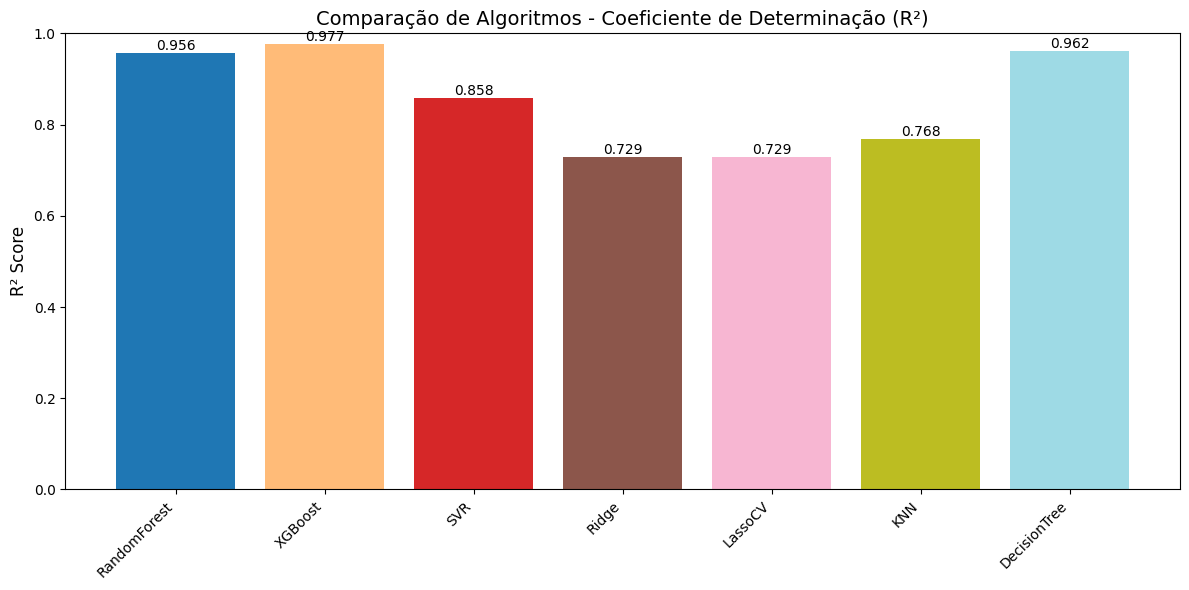

In [ ]:
algorithms = list(results.keys())
r2_scores = [results[alg]['R²'] for alg in algorithms]
rmse_scores = [results[alg]['RMSE'] for alg in algorithms]

plt.style.use('seaborn-v0_8-deep')
colors = plt.cm.tab20(np.linspace(0, 1, len(algorithms)))

plt.figure(figsize=(12, 6))
bars = plt.bar(algorithms, r2_scores, color=colors)
plt.title('Comparação de Algoritmos - Coeficiente de Determinação (R²)', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


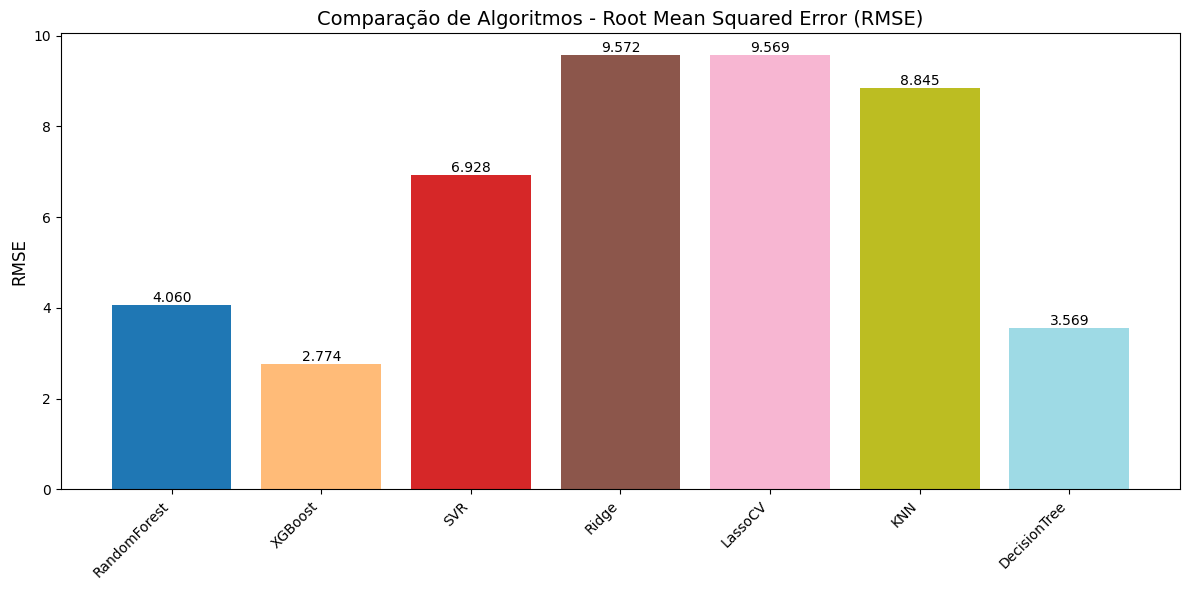

In [ ]:


plt.figure(figsize=(12, 6))
bars = plt.bar(algorithms, rmse_scores, color=colors)
plt.title('Comparação de Algoritmos - Root Mean Squared Error (RMSE)', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()